In [28]:
import numpy as np
import pywinauto
import pydirectinput
import cv2
from mss import mss
import pytesseract
from matplotlib import pyplot as plt
import time
import torch
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
import win32api
import win32con
import time

def click(x, y):
    win32api.SetCursorPos((x, y))
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTDOWN, 0, 0)
    time.sleep(0.1) 
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTUP, 0, 0)
    time.sleep(0.1)
#actions = [left,right,up,down,z,x,c,v,g,a]
class RiskofRainEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0,high=255,shape=(1,300,300), dtype=np.uint8)
        self.action_space = Discrete(12)
        #define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':300, 'left':0, 'width':800, 'height':600}
        self.done_location = {'top':725, 'left':300, 'width':120, 'height':50}
    def step(self,action):
        # action key -0 = space, 1-4, left,right,up,down 5-9 z,x,c,v,g use 10, 11 no op
        action_map ={
            0:'space',
            1:'left',
            2:'right',
            3:'up',
            4:'down',
            5:'z',
            6:'x',
            7:'c',
            8:'v',
            9:'g',
            10:'a',
            11:'no op',
        }
        if action !=11:
            pydirectinput.press(action_map[action])
        #check if game is done
        done, done_cap = self.get_done()
        #get next obs
        new_observation = self.get_observation()
        reward = 1
        info = {}
        truncated = False
        return new_observation, reward, done,truncated, info
    def render(self):
        cv2.imshow('Game',np.array(self.cap(self.game_location))[:,:,:2])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close();
    def close(self):
        cv2.destroyAllWindows()
    def reset(self,seed=None):
        self.seedNum = seed
        time.sleep(1)
        pydirectinput.click(x=404,y=745)
        click(404,745)
        pydirectinput.press('space')
        info = {}
        return self.get_observation(),info
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        #resize 
        resized = cv2.resize(gray, (300,300))
        #channel
        channel = np.reshape(resized, (1,300,300))
        return channel
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        
        done_strings = ['Try Again?', 'Try', 'Again', 'Agaim','Try ']
        
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done,done_cap
#     def get_time(self):
#         time_cap = np.array(self.cap.grab)

In [29]:
env = RiskofRainEnv()

In [47]:
env.action_space.sample()

10

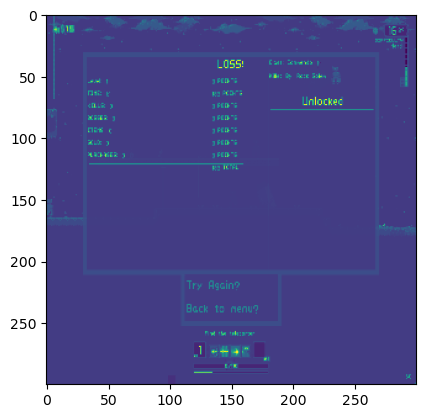

In [48]:
plt.imshow(env.get_observation()[0])

In [49]:
done,done_cap = env.get_done()

In [50]:
done

True

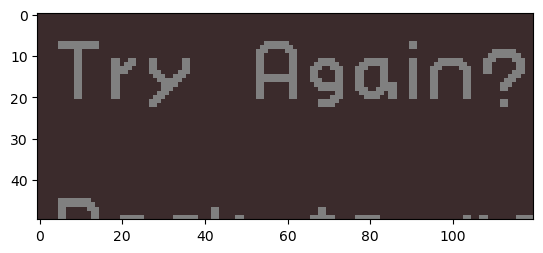

In [51]:
plt.imshow(done_cap)

In [45]:
done

'Try '

In [12]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'totalReward for episode {episode} is {total_reward}')

totalReward for episode 0 is 333
totalReward for episode 1 is 170
totalReward for episode 2 is 209
totalReward for episode 3 is 114
totalReward for episode 4 is 159
totalReward for episode 5 is 141


KeyboardInterrupt: 

In [30]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
env_checker.check_env(env)

In [ ]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self,check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n)calls)
            self.model.save(model_parth)
            
        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = '/logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [ ]:
from stable_baselines3 import DQN

In [32]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000, learning_starts=1000)
#Use CnnPolicy on OUr env, log the tensorboard, increase/decrease buffer based on hardware limitations, start learning after 1000 frames

NameError: name 'DQN' is not defined

In [33]:
#Start training
model.learn(total_timesteps=5000,callback=callback)
#probably increase this by a large amount